In [1]:
import pickle
import numpy as np
import pandas as pd
import gensim
from sklearn.model_selection import train_test_split
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, Conv1D, BatchNormalization, GlobalMaxPooling1D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 140)

tweets_text = pd.read_csv("final_dataset_improved.txt", sep='\t', header=None)
tweets_text.columns = ['Text','Label']

print("Out of {} rows, {} are spams, {} are non-spams".format(len(tweets_text),
                                                              len(tweets_text[tweets_text['Label']=='Spam']),
                                                              len(tweets_text[tweets_text['Label']=='Ham'])))

Out of 3994608 rows, 1725268 are spams, 2269340 are non-spams


In [3]:
tweets_text.isnull().sum()

Text     0
Label    0
dtype: int64

In [4]:
# Convert labels to numeric format
tweets_text['Label'] = np.where(tweets_text['Label']=='Spam',1,0)

X_train, X_test, y_train, y_test = train_test_split(tweets_text['Text'], tweets_text['Label'], 
                                                    test_size=0.01, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.010101, random_state=2)

In [5]:
# Convert labels to numpy arrays
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

In [6]:
print("Training data: {} ({}%)\nTest data: {} ({}%)\nValidation data: {} ({}%)".format(len(X_train), round((len(X_train)/len(tweets_text))*100), 
                                                                                       len(X_test), round((len(X_test)/len(tweets_text))*100), 
                                                                                       len(X_val), round((len(X_val)/len(tweets_text))*100)))

Training data: 3914714 (98%)
Test data: 39947 (1%)
Validation data: 39947 (1%)


In [28]:
# Train the tokenizer and use that tokenizer to convert sentences into sequences of numbers
tokenizer = Tokenizer(oov_token='<OOV>', filters='') 
tokenizer.fit_on_texts(X_train)
print("Number of vocabulary: {}".format(len(tokenizer.word_index)))
print(tokenizer.word_index)

Number of vocabulary: 41763
{'<OOV>': 1, 'usermention': 2, 'url': 3, 'retweet': 4, 'get': 5, 'new': 6, 'make': 7, 'like': 8, 'love': 9, 'good': 10, 'time': 11, 'day': 12, 'know': 13, 'one': 14, 'think': 15, 'twitter': 16, 'see': 17, 'say': 18, 'free': 19, 'work': 20, 'look': 21, 'want': 22, 'need': 23, 'thank': 24, 'today': 25, 'come': 26, 'take': 27, 'post': 28, 'great': 29, 'video': 30, 'back': 31, 'use': 32, 'watch': 33, 'home': 34, 'follow': 35, 'people': 36, 'best': 37, 'market': 38, 'live': 39, 'news': 40, 'check': 41, 'really': 42, 'find': 43, 'right': 44, 'show': 45, 'money': 46, 'game': 47, 'way': 48, 'would': 49, 'life': 50, 'feel': 51, 'well': 52, 'man': 53, 'still': 54, 'try': 55, 'start': 56, 'help': 57, 'night': 58, 'much': 59, 'tweet': 60, 'world': 61, 'business': 62, 'let': 63, 'give': 64, 'last': 65, 'play': 66, 'first': 67, 'please': 68, 'call': 69, 'wait': 70, 'happy': 71, 'via': 72, 'tell': 73, 'better': 74, 'job': 75, 'week': 76, 'even': 77, 'year': 78, 'never': 79

In [29]:
with open('tokenizer_random.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
#Load the tokenizer
with open('tokenizer_random.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

print("Number of vocabulary: {}".format(len(tokenizer.word_index)))

Number of vocabulary: 41763


In [8]:
def text_processing(data, maxlen):
    seq = tokenizer.texts_to_sequences(data)
    seq_pad = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')
    return seq_pad

In [9]:
X_train_seq_padded = text_processing(X_train,20)
X_test_seq_padded = text_processing(X_test,20)
X_val_seq_padded = text_processing(X_val,20)

In [10]:
X_train_seq_padded.shape

(3914714, 20)

In [11]:
X_test_seq_padded.shape

(39947, 20)

In [12]:
X_val_seq_padded.shape

(39947, 20)

In [13]:
def model_lstm():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, mask_zero=True, input_length=max_len))
    model.add(LSTM(32, dropout=0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [13]:
def model_bilstm():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, mask_zero=True, input_length=max_len))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [13]:
def model_cnn():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, input_length=max_len, 
                        weights=None, trainable=True))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model   

# Implement Transformer 

In [14]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=1.0))
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim, embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=1.0))

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [14]:
vocab_size=len(tokenizer.word_index)+1
maxlen=20
print(vocab_size)

41764


In [16]:
def model_transformer():    
    embed_dim = 50  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
def plot_graphs(history, metrics, title, epochs):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+metrics])
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.xticks(range(0,epochs))
    plt.legend([metrics, 'val_'+metrics], loc='best')
    plt.show()

In [16]:
max_len = 20
model = model_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 50)            2088200   
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,099,913
Trainable params: 2,099,913
Non-trainable params: 0
_________________________________________________________________


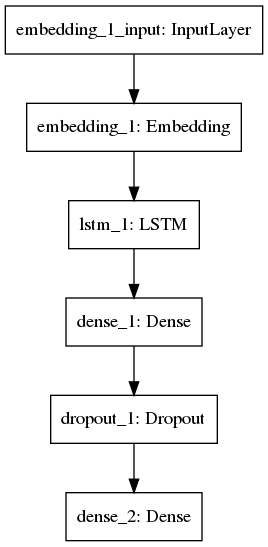

In [20]:
tf.keras.utils.plot_model(model, "lstm_glove.png")

In [ ]:
# Initialize the embedding weights randomly (Random Embedding Weights Initialization)
model.layers[0].set_weights([np.random.randn(vocab_size, 50)])
# Compile the model
tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks list
#filepath = 'lstm_normal_random.hdf5'
#filepath = 'cnn_normal_random.hdf5'
#filepath = 'transformer_normal_random.hdf5'
#filepath = 'bilstm_normal_random.hdf5'

callbacks_list = [ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)]

# Train model
batch_size = 512
epochs = 8

with tf.device('/device:GPU:3'):
    history = model.fit(X_train_seq_padded, y_train, batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val_seq_padded, y_val), verbose=1, callbacks=callbacks_list)

Epoch 1/8
7646/7646 [==============================] - ETA: 0s - loss: 0.5377 - accuracy: 0.7496
Epoch 1: val_loss improved from inf to 0.50077, saving model to lstm_normal_random8.hdf5
7646/7646 [==============================] - 1033s 133ms/step - loss: 0.5377 - accuracy: 0.7496 - val_loss: 0.5008 - val_accuracy: 0.7689
Epoch 2/8
7646/7646 [==============================] - ETA: 0s - loss: 0.5131 - accuracy: 0.7653
Epoch 2: val_loss improved from 0.50077 to 0.49202, saving model to lstm_normal_random8.hdf5
7646/7646 [==============================] - 1012s 132ms/step - loss: 0.5131 - accuracy: 0.7653 - val_loss: 0.4920 - val_accuracy: 0.7743
Epoch 3/8
7646/7646 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.7699
Epoch 3: val_loss improved from 0.49202 to 0.48696, saving model to lstm_normal_random8.hdf5
7646/7646 [==============================] - 927s 121ms/step - loss: 0.5051 - accuracy: 0.7699 - val_loss: 0.4870 - val_accuracy: 0.7757
Epoch 4/8
6506/7646 [

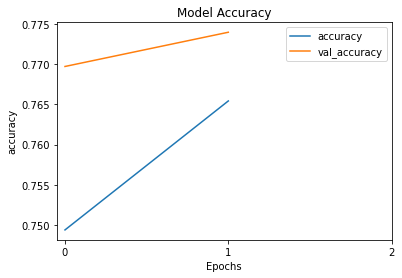

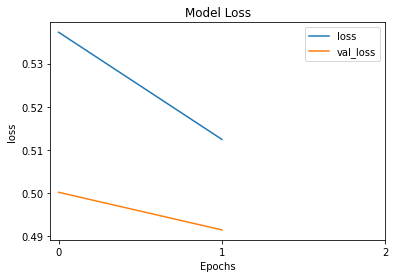

In [18]:
plot_graphs(history, 'accuracy', 'Model Accuracy',3)
plot_graphs(history, 'loss', 'Model Loss',3)

In [19]:
model = load_model('lstm_normal_random.hdf5', compile=False)
#model = load_model('cnn_normal_random.hdf5', compile=False)
#model = load_model('transformer_normal_random.hdf5', compile=False)

tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
train_loss, train_acc = model.evaluate(X_train_seq_padded, y_train, batch_size=512, verbose=1)

print("Train Accuracy: {}".format(round(train_acc,3)))
print("Train Loss: {}".format(round(train_loss,3)))

7646/7646 [==============================] - 489s 59ms/step - loss: 0.4900 - accuracy: 0.7752
Train Accuracy: 0.775
Train Loss: 0.49


In [21]:
val_loss, val_acc = model.evaluate(X_val_seq_padded, y_val, batch_size=1, verbose=1)

print("Validation Accuracy: {}".format(round(val_acc,3)))
print("Validation Loss: {}".format(round(val_loss,3)))

39947/39947 [==============================] - 395s 10ms/step - loss: 0.4914 - accuracy: 0.7740
Validation Accuracy: 0.774
Validation Loss: 0.491


In [22]:
test_loss, test_acc = model.evaluate(X_test_seq_padded, y_test, batch_size=1, verbose=1)

print("Test Accuracy: {}".format(round(test_acc,3)))
print("Test Loss: {}".format(round(test_loss,3)))

39947/39947 [==============================] - 409s 10ms/step - loss: 0.4937 - accuracy: 0.7737
Test Accuracy: 0.774
Test Loss: 0.494


In [23]:
y_pred = (model.predict(X_test_seq_padded)>0.5).astype("int32")

print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, y_pred),3)))
print("Recall: {}".format(round(recall_score(y_test, y_pred),3)))
print("F-Measure: {}".format(round(f1_score(y_test, y_pred),3)))

1249/1249 [==============================] - 60s 12ms/step
Accuracy: 0.774
Precision: 0.765
Recall: 0.689
F-Measure: 0.725


In [24]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.84      0.81     22629
           1       0.77      0.69      0.73     17318

    accuracy                           0.77     39947
   macro avg       0.77      0.76      0.77     39947
weighted avg       0.77      0.77      0.77     39947



Text(0.5, 1.0, 'Confusion Matrix')

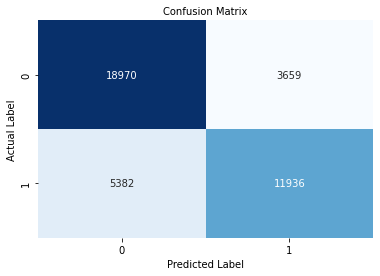

In [25]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues)
plt.ylabel('Actual Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)

In [26]:
X_test.head()

2354087             top fashion trend summer url
3313731                             save use url
3975146                         keyboard nut win
981380                   cant wait get new album
2590449    coach train click click step step url
Name: Text, dtype: object

In [27]:
y_pred[0:5]

array([[1],
       [1],
       [0],
       [0],
       [1]])

In [28]:
y_test[0:5]

array([1, 1, 1, 0, 1])

In [29]:
df_list = list(X_test.values)
df = pd.DataFrame(df_list, columns=["text"])
df["actual"] = y_test
df["predicted"] = y_pred

incorrect = df[df["actual"] != df["predicted"]]

In [30]:
incorrect

,text,actual,predicted
2,keyboard nut win,1,0
14,short sweet tip design web article quickly run url,0,1
15,usermention follow ask question please,0,1
17,usermention guy think check url,1,0
25,new plan add top customer rat new floor plan add url,0,1
...,...,...,...
39917,solo url,1,0
39918,phone die suck,1,0
39921,subscribe channel url,0,1
39928,usermention way make menace,1,0


In [31]:
#export incorrect
incorrect.to_csv('incorrect_lstm_normal_random.txt', sep='\t', index=False, header=False)

In [32]:
df_list = list(X_test.values)
df1 = pd.DataFrame(df_list, columns=["text"])
df1["actual"] = y_test
df1["predicted"] = y_pred

correct = df1[df1["actual"] == df1["predicted"]]

In [33]:
correct

,text,actual,predicted
0,top fashion trend summer url,1,1
1,save use url,1,1
3,cant wait get new album,0,0
4,coach train click click step step url,1,1
5,yes dose,0,0
...,...,...,...
39942,ana ser url,0,0
39943,usermention backup,0,0
39944,photo colour photograph url,0,0
39945,retweet usermention head strip club cant find bag nickel,0,0


In [34]:
#export correct
correct.to_csv('correct_lstm_normal_random.txt', sep='\t', index=False, header=False)

# End of LSTM Model

# Start of CNN Model

In [18]:
max_len = 20
model = model_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 50)            2088200   
                                                                 
 conv1d (Conv1D)             (None, 18, 256)           38656     
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dropout (Dropout)           (None, 32)                0

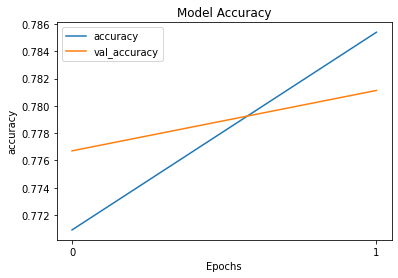

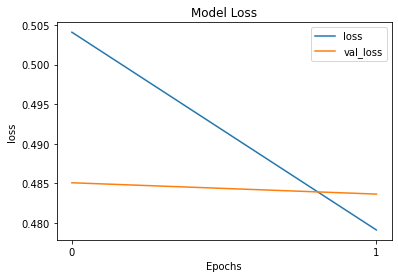

In [54]:
plot_graphs(history, 'accuracy', 'Model Accuracy',2)
plot_graphs(history, 'loss', 'Model Loss',2)

In [17]:
model = load_model('cnn_normal_random.hdf5', compile=False)

tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
train_loss, train_acc = model.evaluate(X_train_seq_padded, y_train, batch_size=512, verbose=1)

print("Train Accuracy: {}".format(round(train_acc,3)))
print("Train Loss: {}".format(round(train_loss,3)))

7646/7646 [==============================] - 138s 17ms/step - loss: 0.4851 - accuracy: 0.7796
Train Accuracy: 0.78
Train Loss: 0.485


In [19]:
val_loss, val_acc = model.evaluate(X_val_seq_padded, y_val, batch_size=1, verbose=1)

print("Validation Accuracy: {}".format(round(val_acc,3)))
print("Validation Loss: {}".format(round(val_loss,3)))

39947/39947 [==============================] - 88s 2ms/step - loss: 0.4924 - accuracy: 0.7736
Validation Accuracy: 0.774
Validation Loss: 0.492


In [20]:
test_loss, test_acc = model.evaluate(X_test_seq_padded, y_test, batch_size=1, verbose=1)

print("Test Accuracy: {}".format(round(test_acc,3)))
print("Test Loss: {}".format(round(test_loss,3)))

39947/39947 [==============================] - 88s 2ms/step - loss: 0.4953 - accuracy: 0.7731
Test Accuracy: 0.773
Test Loss: 0.495


In [21]:
y_pred = (model.predict(X_test_seq_padded)>0.5).astype("int32")

print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, y_pred),3)))
print("Recall: {}".format(round(recall_score(y_test, y_pred),3)))
print("F-Measure: {}".format(round(f1_score(y_test, y_pred),3)))

1249/1249 [==============================] - 4s 3ms/step
Accuracy: 0.773
Precision: 0.738
Recall: 0.738
F-Measure: 0.738


In [22]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     22629
           1       0.74      0.74      0.74     17318

    accuracy                           0.77     39947
   macro avg       0.77      0.77      0.77     39947
weighted avg       0.77      0.77      0.77     39947



Text(0.5, 1.0, 'Confusion Matrix')

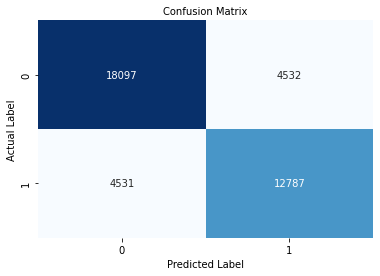

In [23]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues)
plt.ylabel('Actual Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)

# Start of Transformer Model

In [33]:
max_len = 20
#model = model_lstm()
#model = model_cnn()
model = model_transformer()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddin  (None, 20, 50)           2089200   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 20, 50)           23832     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_4 (Dropout)         (None, 50)                0     

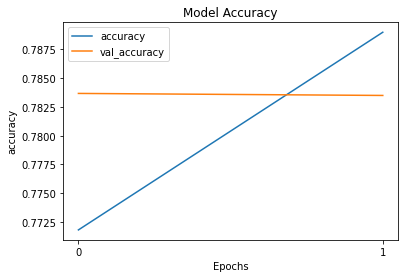

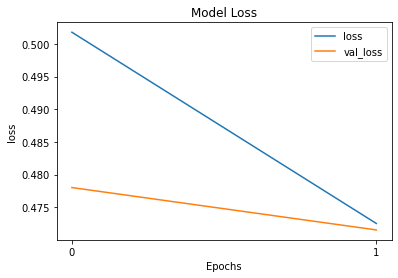

In [21]:
plot_graphs(history, 'accuracy', 'Model Accuracy',2)
plot_graphs(history, 'loss', 'Model Loss',2)

In [22]:
model = load_model('transformer_normal_random.hdf5', compile=False)

tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
train_loss, train_acc = model.evaluate(X_train_seq_padded, y_train, batch_size=512, verbose=1)

print("Train Accuracy: {}".format(round(train_acc,3)))
print("Train Loss: {}".format(round(train_loss,3)))

7646/7646 [==============================] - 151s 20ms/step - loss: 0.4458 - accuracy: 0.8035
Train Accuracy: 0.803
Train Loss: 0.446


In [23]:
val_loss, val_acc = model.evaluate(X_val_seq_padded, y_val, batch_size=1, verbose=1)

print("Validation Accuracy: {}".format(round(val_acc,3)))
print("Validation Loss: {}".format(round(val_loss,3)))

39947/39947 [==============================] - 122s 3ms/step - loss: 0.4715 - accuracy: 0.7835
Validation Accuracy: 0.783
Validation Loss: 0.472


In [24]:
test_loss, test_acc = model.evaluate(X_test_seq_padded, y_test, batch_size=1, verbose=1)

print("Test Accuracy: {}".format(round(test_acc,3)))
print("Test Loss: {}".format(round(test_loss,3)))

39947/39947 [==============================] - 118s 3ms/step - loss: 0.4724 - accuracy: 0.7842
Test Accuracy: 0.784
Test Loss: 0.472


In [25]:
y_pred = (model.predict(X_test_seq_padded)>0.5).astype("int32")

print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, y_pred),3)))
print("Recall: {}".format(round(recall_score(y_test, y_pred),3)))
print("F-Measure: {}".format(round(f1_score(y_test, y_pred),3)))

1249/1249 [==============================] - 6s 4ms/step
Accuracy: 0.784
Precision: 0.806
Recall: 0.661
F-Measure: 0.727


In [26]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82     22629
           1       0.81      0.66      0.73     17318

    accuracy                           0.78     39947
   macro avg       0.79      0.77      0.77     39947
weighted avg       0.79      0.78      0.78     39947



Text(0.5, 1.0, 'Confusion Matrix')

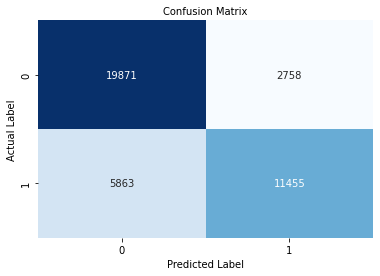

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues)
plt.ylabel('Actual Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)

# Start of Bi-LSTM Model

In [16]:
max_len = 20
model = model_bilstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 50)            2088200   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              58880     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,151,241
Trainable params: 2,151,241
Non-trainable params: 0
______________________________________________

In [ ]:
model = load_model('bilstm_normal_random.hdf5', compile=False)

tf.random.set_seed(1234)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

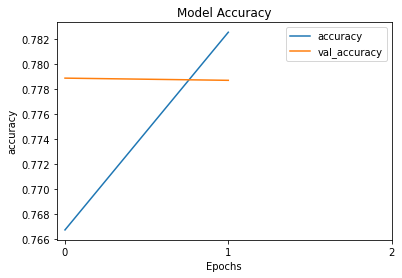

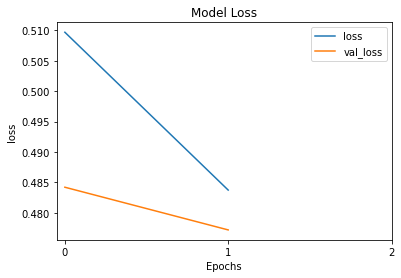

In [18]:
plot_graphs(history, 'accuracy', 'Model Accuracy',3)
plot_graphs(history, 'loss', 'Model Loss',3)

In [19]:
train_loss, train_acc = model.evaluate(X_train_seq_padded, y_train, batch_size=512, verbose=1)

print("Train Accuracy: {}".format(round(train_acc,3)))
print("Train Loss: {}".format(round(train_loss,3)))

7646/7646 [==============================] - 1147s 150ms/step - loss: 0.4654 - accuracy: 0.7893
Train Accuracy: 0.789
Train Loss: 0.465


In [20]:
val_loss, val_acc = model.evaluate(X_val_seq_padded, y_val, batch_size=1, verbose=1)

print("Validation Accuracy: {}".format(round(val_acc,3)))
print("Validation Loss: {}".format(round(val_loss,3)))

39947/39947 [==============================] - 327s 8ms/step - loss: 0.4772 - accuracy: 0.7787
Validation Accuracy: 0.779
Validation Loss: 0.477


In [21]:
test_loss, test_acc = model.evaluate(X_test_seq_padded, y_test, batch_size=1, verbose=1)

print("Test Accuracy: {}".format(round(test_acc,3)))
print("Test Loss: {}".format(round(test_loss,3)))

39947/39947 [==============================] - 295s 7ms/step - loss: 0.4792 - accuracy: 0.7791
Test Accuracy: 0.779
Test Loss: 0.479


In [22]:
y_pred = (model.predict(X_test_seq_padded)>0.5).astype("int32")

print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred),3)))
print("Precision: {}".format(round(precision_score(y_test, y_pred),3)))
print("Recall: {}".format(round(recall_score(y_test, y_pred),3)))
print("F-Measure: {}".format(round(f1_score(y_test, y_pred),3)))

1249/1249 [==============================] - 63s 13ms/step
Accuracy: 0.779
Precision: 0.801
Recall: 0.653
F-Measure: 0.719


In [23]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.88      0.82     22629
           1       0.80      0.65      0.72     17318

    accuracy                           0.78     39947
   macro avg       0.78      0.76      0.77     39947
weighted avg       0.78      0.78      0.78     39947



Text(0.5, 1.0, 'Confusion Matrix')

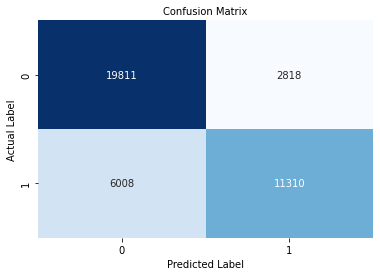

In [24]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cbar=False, cmap=plt.cm.Blues)
plt.ylabel('Actual Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)